# Time Causal VAE

In [8]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
sys.path.append('../../../..')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data used in original paper

(2516, 2)


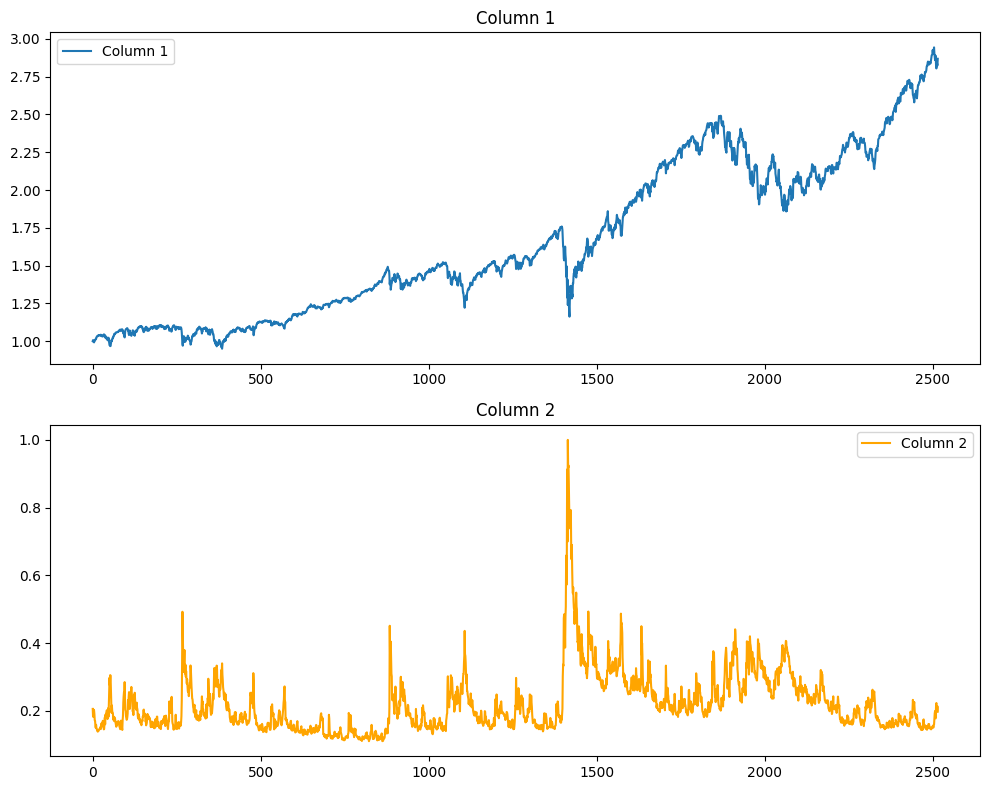

In [9]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/sp500vix/sp500vix_normalized.npy")
print(data.shape)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(data[:, 0], label="Column 1")
axs[0].set_title("Column 1")
axs[0].legend()

axs[1].plot(data[:, 1], label="Column 2", color="orange")
axs[1].set_title("Column 2")
axs[1].legend()

plt.tight_layout()
plt.show()


## Create Data for Master Thesis

In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices.csv", index_col = 0)
# df["vol"] = df["Close"].rolling(window=30).std()
# df = df.dropna()
price_scaler = data[0, 0]
vol_scaler = np.max(data[:, 1])
data = df.to_numpy()
data[:, 0] = data[:, 0]/price_scaler
data[:, 1] = data[:, 1]/vol_scaler
print(data.shape)
np.save("../data/sp500vix/sp500_normalized.npy", data)



(1089, 2)


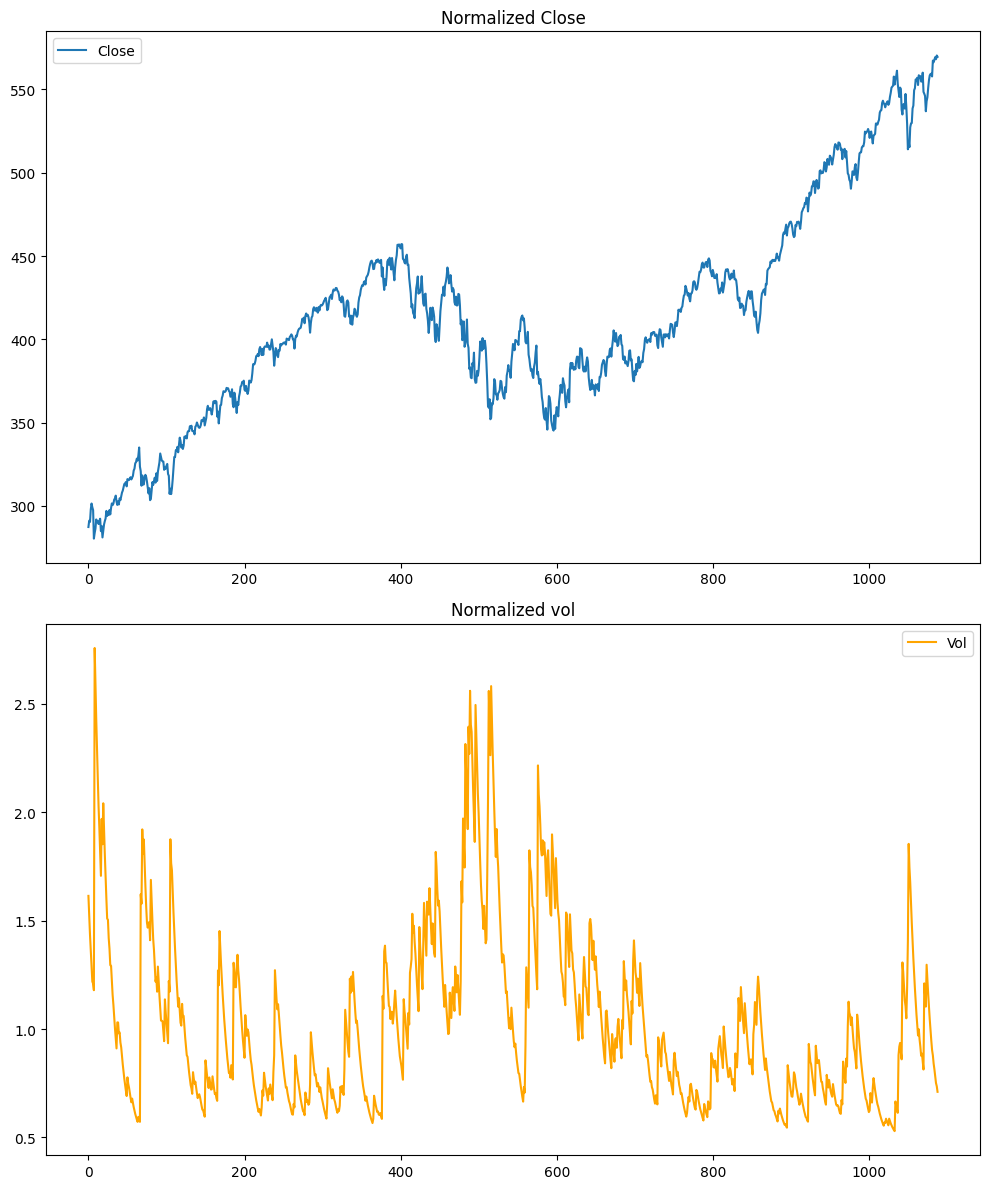

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(data[:, 0], label="Close")
axs[0].set_title("Normalized Close")
axs[0].legend()

axs[1].plot(data[:, 1], label="Vol", color="orange")
axs[1].set_title("Normalized vol")
axs[1].legend()

# axs[2].plot(rolling_volatility, label="30-Day Rolling Volatility", color="green")
# axs[2].set_title("30-Day Rolling Volatility of Column 1")
# axs[2].legend()

plt.tight_layout()
plt.show()

## TCVAE Model

In [12]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/Master/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0
Setting ramdom seed: 0


In [13]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: Master
Loading dataset: Master
Base dataset initialized
Load networks:
Load networks:


In [14]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [15]:
train_pipeline.train(log_output=True)

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-03-26_08-58-57. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100: 100%|██████████| 5/5 [00:00<00:00, 21.92batch/s]total loss: 11.87
recon: 11.87
reg: -0.20
Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  4.60batch/s]
--------------------------------------------------------------------------
Train loss: 13.042
-------------------------------------------------------------

In [16]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99, n_sample_test=1000)
ds = model_evaluator.data_ppl.base_dataset

real_data = test_data
recon_data = recon_data
fake_data = gen_data

Base dataset initialized


## Real Data (l) and Fake Data (r)

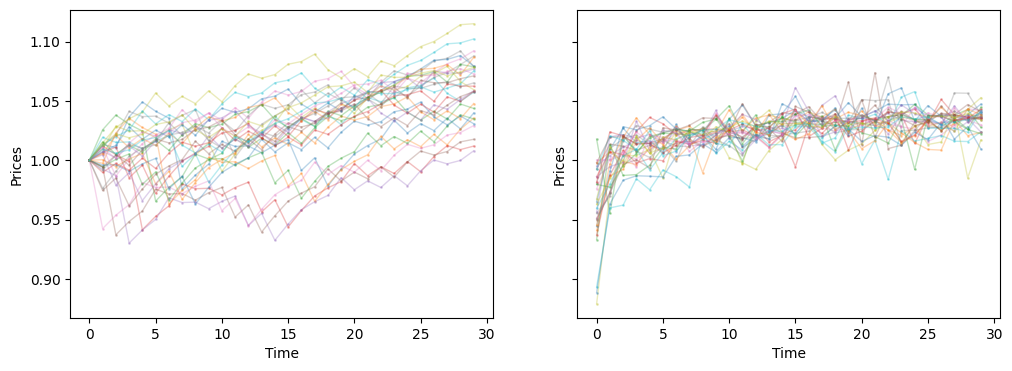

In [17]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data, plot_size=30)

In [18]:
fake_data.shape

torch.Size([1000, 30, 1])

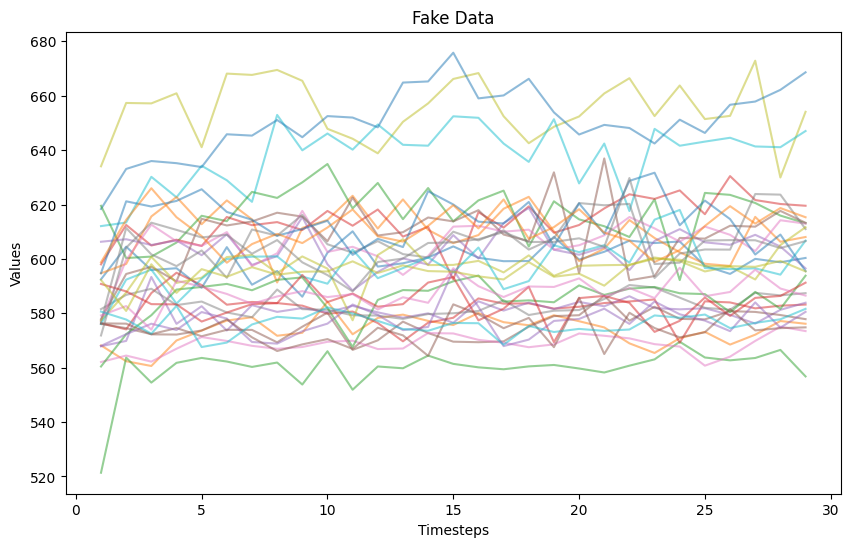

In [24]:
sys.path.append('../../../..')
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config

df_post_processed = post_processing(pd.DataFrame(fake_data.detach().squeeze(-1).numpy()), **post_processing_config)

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(30):  # Iterate over samples
    ax.plot(df_post_processed.loc[i, :], alpha=0.5)  # Plot each sample

ax.set_title("Fake Data")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Values")
plt.show()

In [22]:
df_post_processed.head()

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,22.484531,33.912750,25.756441,26.395802,19.479591,33.748512,20.575424,25.416338,16.308262,31.820078,...,29.420879,32.138916,36.004410,35.172810,35.697567,27.228966,24.396564,29.666872,28.486547,29.990448
1,-1.371542,-7.228953,-9.005570,0.441456,4.072205,7.718416,8.930244,2.176570,3.260141,14.510843,...,7.476981,5.220574,-0.609927,-4.169260,1.287456,3.593842,-1.066704,2.570146,7.549307,6.555455
2,-50.352486,-5.877821,-15.244160,-7.835104,-6.000972,-7.344477,-9.354840,-7.722905,-15.979925,-3.529802,...,-9.952215,-11.444366,-8.891597,-6.543544,-0.019444,-5.841433,-6.903872,-6.027150,-3.031880,-12.916335
3,6.722787,4.509011,17.603676,24.805122,20.447168,13.447242,14.422332,14.020473,13.095471,10.192109,...,12.693987,14.036319,14.612138,15.323578,-0.375455,14.654195,14.261662,12.126449,13.081998,13.487204
4,-1.689000,0.283382,23.320431,6.525517,12.898038,4.096134,13.290747,10.856184,12.236499,10.721037,...,14.440944,12.870547,16.476658,12.228464,11.779408,12.163714,9.784283,6.613543,11.600517,14.150354
